# Using Keras for Image Classification. Images downloaded from Google.
Reference: https://keras.io/examples/vision/image_classification_from_scratch/ 

## Downloading Images and Creating Dataset

## Downloading Images

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [6]:
! mkdir "/content/drive/MyDrive/data"

In [7]:
! pip install icrawler

  Created wheel for icrawler: filename=icrawler-0.6.4-py2.py3-none-any.whl size=35063 sha256=843bdfce55b2e20d0365878546017514caec66ecc41550bf0137392111ed53d4
  Stored in directory: /root/.cache/pip/wheels/57/f7/08/e89027083863374b83f7b3e3ce52a9afa1674424a379c7faf9
Successfully built icrawler


In [20]:
root_dir = "/content/drive/My Drive/data"

In [ ]:
from icrawler.builtin import GoogleImageCrawler

google_crawler = GoogleImageCrawler(storage={'root_dir': root_dir + '/birds'})
google_crawler.crawl(keyword='bird', max_num=100)

In [ ]:
google_crawler = GoogleImageCrawler(storage={'root_dir': root_dir + '/dogs'})
google_crawler.crawl(keyword='dog', max_num=100)

In [ ]:
google_crawler = GoogleImageCrawler(storage={'root_dir': root_dir + '/cats'})
google_crawler.crawl(keyword='cat', max_num=100)

## CNN for Image classification using Pytorch

In [11]:
# importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

In [13]:
image=[]
labels=[]
for file in os.listdir(root_dir):
    if file=='birds':
      for c in os.listdir(os.path.join(root_dir, file)):
        image.append(c)
        labels.append('birds')
    if file=='cats':
      for c in os.listdir(os.path.join(root_dir, file)):
            image.append(c)
            labels.append('cats')
    if file=='dogs':
        for c in os.listdir(os.path.join(root_dir, file)):
          image.append(c)
          labels.append('dogs')

data = {'Images':image, 'labels':labels} 
data = pd.DataFrame(data) 
data.head()

,Images,labels
0,000001.png,birds
1,000002.jpg,birds
2,000003.jpg,birds
3,000004.jpg,birds
4,000005.jpg,birds


In [14]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,labels,encoded_labels
0,000001.png,birds,0
1,000002.jpg,birds,0
2,000003.jpg,birds,0
3,000004.jpg,birds,0
4,000005.jpg,birds,0


## Keras Image Classifier:

Referenced from: https://keras.io/examples/vision/image_classification_from_scratch/

In [22]:
import keras 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
# removing corrupt images 
import os

num_skipped = 0
for folder_name in ("birds", "cats", "dogs"):
    folder_path = os.path.join(root_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 48 images


In [24]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 153 files belonging to 3 classes.
Using 123 files for training.
Found 153 files belonging to 3 classes.
Using 30 files for validation.


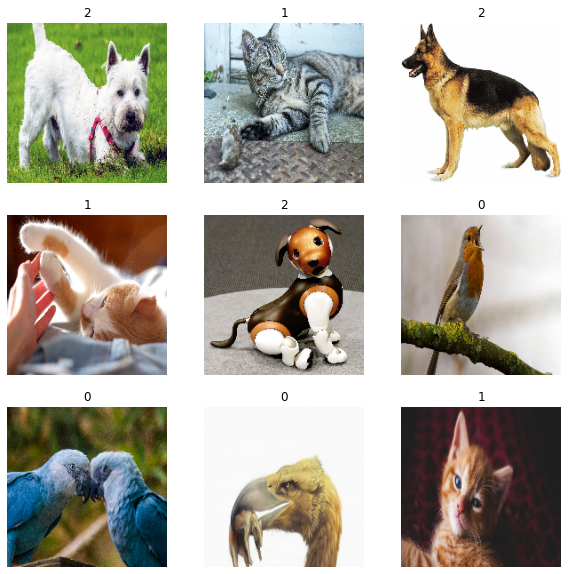

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

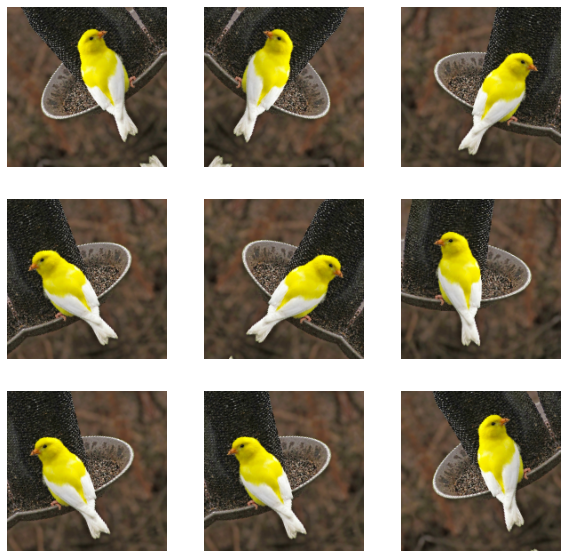

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [28]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [29]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

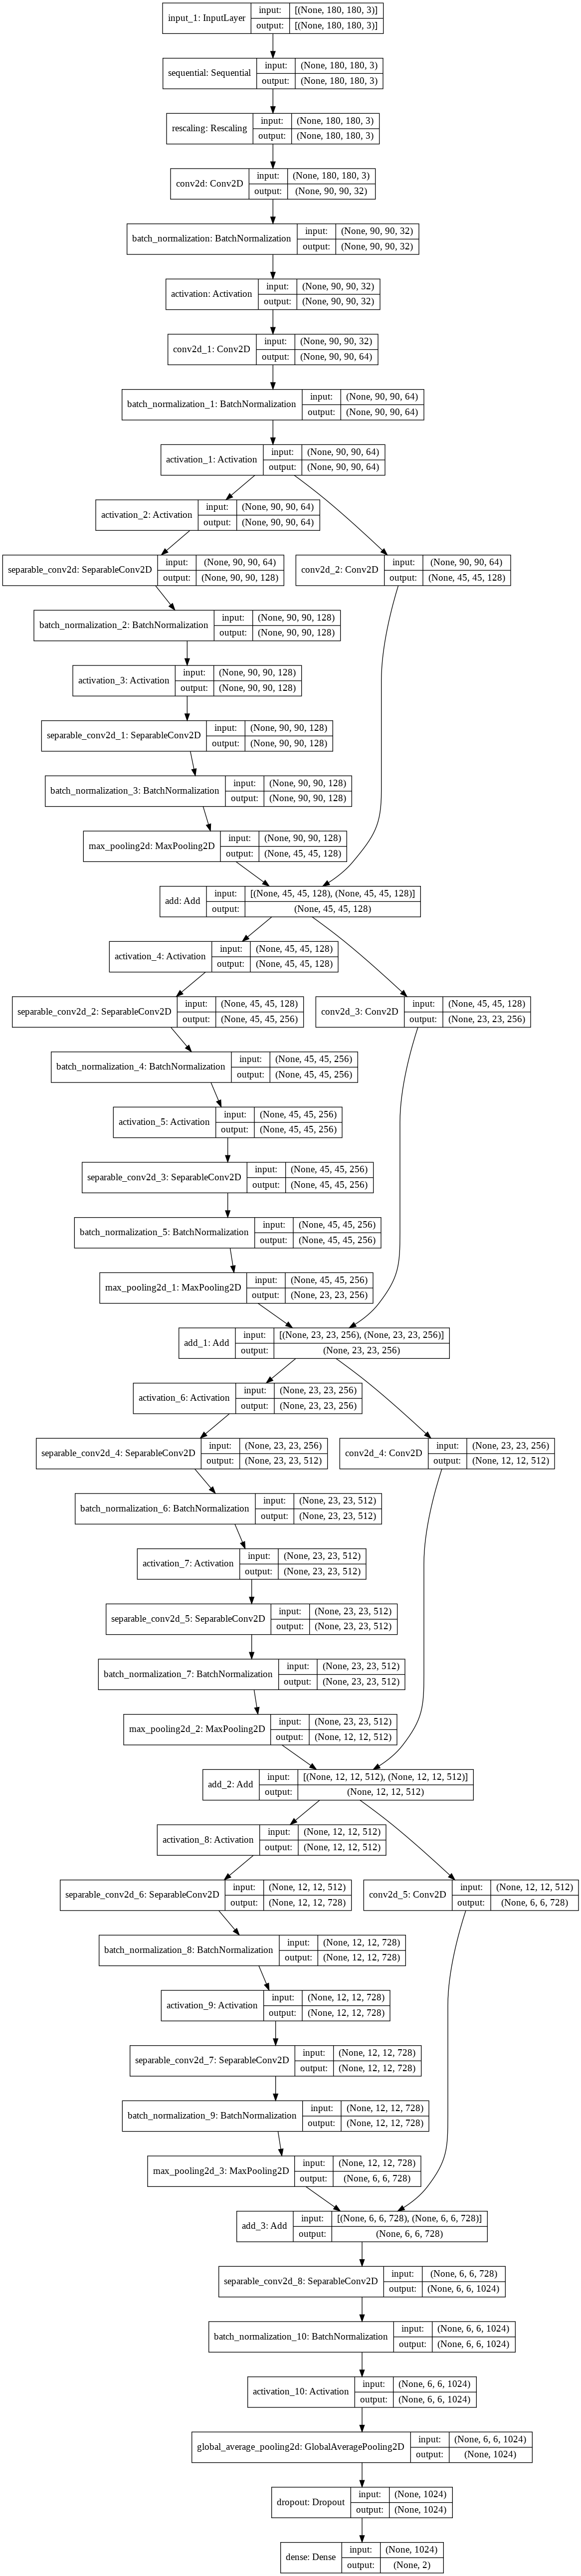

In [30]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
 
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [32]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(), #keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
4/4 [==============================] - 44s 9s/step - loss: 0.8882 - accuracy: 0.4380 - val_loss: 0.7834 - val_accuracy: 0.3000
Epoch 2/50
4/4 [==============================] - 40s 9s/step - loss: 0.9308 - accuracy: 0.3119 - val_loss: 0.7834 - val_accuracy: 0.4333
Epoch 3/50
4/4 [==============================] - 40s 9s/step - loss: 0.8799 - accuracy: 0.3103 - val_loss: 0.7839 - val_accuracy: 0.5000
Epoch 4/50
4/4 [==============================] - 40s 9s/step - loss: 0.9374 - accuracy: 0.4168 - val_loss: 0.7837 - val_accuracy: 0.5000
Epoch 5/50
4/4 [==============================] - 40s 9s/step - loss: 0.7847 - accuracy: 0.4153 - val_loss: 0.7834 - val_accuracy: 0.5000
Epoch 6/50
4/4 [==============================] - 39s 9s/step - loss: 0.8264 - accuracy: 0.3759 - val_loss: 0.7835 - val_accuracy: 0.5000
Epoch 7/50
4/4 [==============================] - 40s 9s/step - loss: 0.8183 - accuracy: 0.3564 - val_loss: 0.7835 - val_accuracy: 0.5000
Epoch 8/50
4/4 [==================

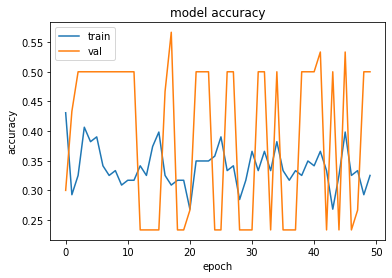

In [37]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

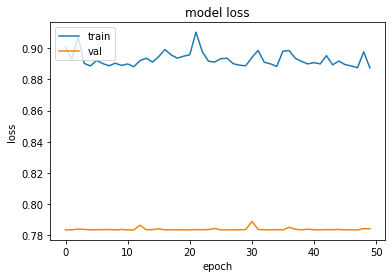

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()